In [1]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [1]:
#hide
from fastbook import *

# Collaborative Filtering Deep Dive

## A First Look at the Data

In [15]:
from fastai.collab import *
from fastai.tabular.all import *
path = Path('/storage/data/ml-100k')

## Learning the Latent Factors

The problem - Recommendation system for users to recommend movies.

Movies - movie factors to represent move properties.

Users - user factors to represent user props

Score for user and movie = (user_factors * movie_factors) + movie_bias

Movie should have a bias factor because a movie could just be generally good/bad likeable or not.

Process:

1. Randomly initialize weights for users, i.e. user_factors and movies, i.e. movie_factors
2. Use SGD to optimize and figure out the weights by assuming linear relationship and loss func MSELoss

In [16]:
# user id | age | gender | occupation | zip code
users = pd.read_csv(path/'u.user', sep='|', names=['user id', 'age', 'gender', 'occupation', 'zip code'])
users.head()

,user id,age,gender,occupation,zip code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [17]:
movies = pd.read_csv(path/'u.item', sep='|', encoding='latin-1', names=["item id", "title"], usecols=[0, 1])
movies.head()

,item id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [18]:
ratings = pd.read_csv(path/'u.data', sep='\t', names=["user id", "item id", "rating", "timestamp"])
ratings.head()

,user id,item id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [19]:
ratings = ratings.merge(movies)
ratings.head()

,user id,item id,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


## Creating the DataLoaders

Independent variables = user_id, movie_title (or item id?)
dependent variable = rating

Skipping DataLoaders specifics here and using the helper from Collab which can read the dataframe and create the batches from specified columns.

In [27]:
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs = 64)
dls.show_batch()

,user id,title,rating
0,451,Conspiracy Theory (1997),5
1,655,Carrie (1976),4
2,100,G.I. Jane (1997),3
3,766,Once Upon a Time in the West (1969),4
4,561,Beavis and Butt-head Do America (1996),1
5,160,Freeway (1996),3
6,212,"Adventures of Priscilla, Queen of the Desert, The (1994)",5
7,552,Kingpin (1996),3
8,268,"Piano, The (1993)",5
9,710,Return of the Jedi (1983),3


In [31]:
# dls.classes
dls.items.iloc[:2,0]

62623    334
16571    617
Name: user id, dtype: int16

In [11]:
user_factors = torch.randn(len(dls.classes['user id']), 5)
movie_factors = torch.randn(len(dls.classes['title']), 5)
movie_bias = torch.randn(len(dls.classes['title']))

In [82]:
a = tensor([ [2, 3], [3, 3], [1, 2]])
b = tensor( [ [1, 2], [1, 1], [0, 2] ])
i = a * b
i, i.sum(dim = 1)

(tensor([[2, 6],
         [3, 3],
         [0, 4]]),
 tensor([8, 6, 4]))

In [12]:
# Defining the model

class MyModel(Module):
    def __init__(self):
        self.user_factors = nn.Parameter(user_factors)
        self.movie_factors = nn.Parameter(movie_factors)
        self.movie_bias = nn.Parameter(movie_bias)
        self.user_bias  = nn.Parameter(torch.randn(len(dls.classes['user id'])))
        
    # Here's where the dependent variable is calculated
    def forward(self, batch):
#         print(f'batch = {batch}')
        users = batch[:,0]
        movies = batch[:,1]
#         print(f'users = {users} movies = {movies}')
        user_factors = self.user_factors[users]
        user_biases = self.user_bias[users]
        movie_factors = self.movie_factors[movies]
        movie_biases = self.movie_bias[movies]
#         print(f'user factors = {user_factors} movie factors = {movie_factors} user_bias = {user_biases} movie biases = {movie_biases}')
        inter = (user_factors * movie_factors).sum(dim=1).squeeze()
#         print(f'inter = {inter}')
        dep_var = inter + movie_biases + user_biases
#         print(f'dep var = {dep_var}')
        return sigmoid_range(dep_var, 0, 5.5)
        

In [13]:
learner = Learner(dls, MyModel(), loss_func=MSELossFlat())

In [14]:
# class Cb(Callback):
#     def after_pred(self):
#         print(f'self prediction = {self.pred}')

# learner.fit_one_cycle(5, cbs=(Cb()))
learner.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,4.183749,4.120216,00:13
1,1.910949,1.914165,00:13
2,1.163058,1.295847,00:13
3,1.006019,1.171367,00:13
4,0.926701,1.157115,00:12


In [27]:
a = torch.randn(3,4)
a

tensor([[ 0.3489, -0.1179, -0.7152,  0.7325],
        [ 1.1617,  2.1429,  0.2987, -1.2615],
        [ 0.3347,  0.5433,  0.2528,  3.3115]])

In [40]:
idx = tensor([ [0, 2] ])
idx

tensor([[0, 2]])

In [44]:
a[:,0][idx]

tensor([[-2.1392,  0.9179]])

## Collaborative Filtering from Scratch

### Weight Decay

In [82]:
def create_params(size, embeddings=True, std_dev=None):
#     print(f'size = {size}')
    if embeddings:
        return Embedding(*size)
    else:
        if not stdev:
            return nn.Parameter(torch.randn(size))
        return nn.Parameter(torch.zeros(size).normal_(0, std_dev))

class CollabModel(Module):
    def __init__(self, num_users, num_movies, num_factors=5, **kwargs):
        self.user_factors = create_params((num_users, num_factors), **kwargs)
        self.movie_factors = create_params((num_movies, num_factors), **kwargs)
        self.movie_bias = create_params((num_movies,1), **kwargs)
        self.user_bias  = create_params((num_users,1), **kwargs)
        
    # Here's where the dependent variable is calculated
    def forward(self, batch):
#         print(f'batch = {batch}')
        users = batch[:,0]
        movies = batch[:,1]
#         print(f'users = {users} movies = {movies}')
        user_factors = self.user_factors(users)
        user_biases = self.user_bias(users)
        movie_factors = self.movie_factors(movies)
        movie_biases = self.movie_bias(movies)
#         print(f'user factors = {user_factors} movie factors = {movie_factors} user_bias = {user_biases} movie biases = {movie_biases}')
        inter = (user_factors * movie_factors).sum(dim=1, keepdim=True)
#         print(f'inter = {inter}')
        dep_var = inter + movie_biases + user_biases
#         print(f'dep var = {dep_var}')
        return sigmoid_range(dep_var, 0, 5.5)

In [15]:
num_users = len(dls.classes['user id'])
num_movies = len(dls.classes['title'])
num_users, num_movies

(944, 1665)

In [12]:
def get_dls():
    return CollabDataLoaders.from_df(ratings, item_name='title', bs = 64)

def get_learner(num_factors=5, **kwargs):
    with no_random():
        dls = get_dls()
        model = CollabModel(num_users, num_movies, num_factors, **kwargs)
        learn = Learner(dls, model, loss_func=MSELossFlat())
        return learn

def do_learning(lr=5e-3, n_epoch=5, wd=None, num_factors=5, **kwargs):
    with no_random():
        learner = get_learner(num_factors, **kwargs)
        learner.fit_one_cycle(n_epoch, lr_max=lr, wd=wd)
        return learner

In [131]:
do_learning(num_factors = 2, n_epoch=2)

epoch,train_loss,valid_loss,time
0,0.891734,0.915192,00:20
1,0.869854,0.895456,00:19


(0.03630780577659607, 3.0199516913853586e-05)

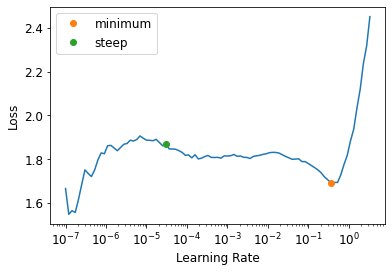

In [97]:
lr_min, lr_steep = learner.lr_find(suggest_funcs=(minimum, steep))
lr_min, lr_steep

Goal:

1. Compare and contrast validation loss across different runs of the learner:
   - Trying learner with different 5 factors and lr = 5e-3 + 1cycle policy
   - Trying learner with 50 factors, lr = 5e-3 + 1cycle policy
   - Trying learner with 5 factors, lr = optimized lr
   - Trying learner with 50 factors, lr = optimized
   - Understand and try fp16
   
   
2. Let's take final validation loss and plot

In [98]:
learner_default = do_learning()

epoch,train_loss,valid_loss,time
0,0.937405,0.949250,00:21
1,0.850926,0.860180,00:20
2,0.806197,0.838182,00:21
3,0.754855,0.832611,00:20
4,0.711426,0.832422,00:19


In [134]:
learner_wd = do_learning(wd=0.1, n_epoch=18)

epoch,train_loss,valid_loss,time
0,1.530535,1.487401,00:20
1,0.969349,0.966689,00:20
2,0.901414,0.903654,00:20
3,0.882743,0.885175,00:19
4,0.851295,0.868502,00:21
5,0.809263,0.856903,00:20
6,0.808095,0.852918,00:19
7,0.805393,0.849616,00:19
8,0.799443,0.847098,00:20
9,0.777543,0.841148,00:20


In [136]:
learner_wd = do_learning(wd=0.1, lr=5e-4, n_epoch=22)

epoch,train_loss,valid_loss,time
0,1.867303,1.830629,00:21
1,1.717396,1.718698,00:20
2,1.504164,1.506793,00:21
3,1.266921,1.238441,00:21
4,1.065852,1.052113,00:21
5,0.938450,0.973713,00:22
6,0.898485,0.940946,00:22
7,0.887001,0.924504,00:21
8,0.878109,0.914426,00:19
9,0.843346,0.907240,00:19


In [108]:
learner_more_epochs = do_learning(n_epoch=8)

epoch,train_loss,valid_loss,time
0,1.095436,1.067706,00:20
1,0.886558,0.891894,00:20
2,0.837943,0.851420,00:20
3,0.789393,0.843047,00:21
4,0.741681,0.838896,00:20
5,0.693952,0.838727,00:21
6,0.660018,0.840624,00:21
7,0.654685,0.841179,00:21


In [109]:
learner_lower_lr = do_learning(lr=5e-4)

epoch,train_loss,valid_loss,time
0,1.695831,1.652232,00:21
1,1.250393,1.244737,00:20
2,1.059151,1.066598,00:21
3,1.018420,1.019176,00:20
4,1.005525,1.013087,00:20


In [110]:
learner_more_facs = do_learning(num_factors=10)

epoch,train_loss,valid_loss,time
0,0.923715,0.944384,00:20
1,0.859417,0.866117,00:20
2,0.804092,0.840077,00:20
3,0.733274,0.832310,00:19
4,0.679719,0.832126,00:21


In [112]:
learner_lower_lr_more_epochs = do_learning(n_epoch=8, lr=5e-4)

epoch,train_loss,valid_loss,time
0,1.790305,1.749128,00:20
1,1.376836,1.366949,00:22
2,1.082047,1.083899,00:20
3,0.987215,0.984727,00:21
4,0.938476,0.951583,00:21
5,0.884977,0.939124,00:20
6,0.879565,0.934987,00:21
7,0.887614,0.934384,00:19


In [113]:
learner_lower_lr_more_facs = do_learning(lr=5e-4, num_factors=10)

epoch,train_loss,valid_loss,time
0,1.691247,1.647450,00:20
1,1.181364,1.175435,00:20
2,1.001643,1.011659,00:21
3,0.968021,0.976882,00:19
4,0.953440,0.972606,00:20


In [114]:
learner_more_facs_more_epochs = do_learning(n_epoch=8, num_factors=10)

epoch,train_loss,valid_loss,time
0,1.021848,1.012394,00:20
1,0.883452,0.886810,00:20
2,0.833790,0.851367,00:20
3,0.761662,0.841638,00:20
4,0.689825,0.842670,00:19
5,0.620493,0.848998,00:20
6,0.579972,0.854381,00:21
7,0.554620,0.855367,00:20


In [115]:
learner_more_facs_more_epochs_lower_lr = do_learning(n_epoch=8, lr=5e-4, num_factors=10)

epoch,train_loss,valid_loss,time
0,1.789018,1.748801,00:19
1,1.330646,1.319231,00:20
2,1.025373,1.029314,00:19
3,0.944904,0.949542,00:21
4,0.897986,0.922336,00:20
5,0.846235,0.911025,00:22
6,0.842727,0.907021,00:22
7,0.848130,0.906436,00:19


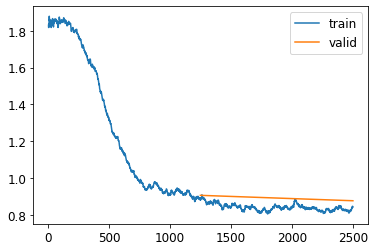

In [90]:
learner.recorder.plot_loss()

### Creating Our Own Embedding Module

## Interpreting Embeddings and Biases

In [26]:
[x for (x,_) in learner.model.named_parameters()]

['user_factors', 'movie_factors', 'movie_bias', 'user_bias']

In [40]:
# len(dls.classes['title']), len(learner.model.movie_bias)
dls.classes['title'][learner.model.movie_bias.argsort()[:5]]

(#5) ['Nina Takes a Lover (1994)','Cyclo (1995)','Germinal (1993)','Caro Diario (Dear Diary) (1994)','Heavyweights (1994)']

In [35]:
torch.argsort?

In [27]:
learner.model.movie_bias
# have titles and biases. How to get movie_bias for each title and then sort
tensor = Tensor([d])

Parameter containing:
tensor([-0.0512, -0.4940, -0.2182,  ..., -0.6179, -0.2527,  0.2381], device='cuda:0', requires_grad=True)

In [ ]:
movie_bias = learner.model.movie_bias.squeeze()
idxs = movie_bias.argsort()[:5]
[dls.classes['title'][i] for i in idxs]

In [ ]:
idxs = movie_bias.argsort(descending=True)[:5]
[dls.classes['title'][i] for i in idxs]

In [ ]:
g = ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_idxs = tensor([learn.dls.classes['title'].o2i[m] for m in top_movies])
movie_w = learn.model.movie_factors[top_idxs].cpu().detach()
movie_pca = movie_w.pca(3)
fac0,fac1,fac2 = movie_pca.t()
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(12,12))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

### Using fastai.collab

In [16]:
def collab_learning():
    with no_random():
        learner = collab_learner(dls, lr=5e-3, wd = 0.1)
        learner.fit_one_cycle(5)
        
collab_learning()

epoch,train_loss,valid_loss,time
0,1.374164,1.265997,00:12
1,1.126385,1.092335,00:13
2,1.034816,1.000066,00:12
3,0.906861,0.917238,00:12
4,0.841281,0.900573,00:13


## Deep Learning Model

In [36]:
doc(Embedding)

In [63]:
class DeepModel(Module):
    def __init__(self, user_sz, movies_sz, n_act):
#         print(f'user_sz = {user_sz} movies_sz = {movies_sz}')
        self.users_factors = Embedding(*user_sz)
        self.movies_factors = Embedding(*movies_sz)
#         self.user_bias = torch.randn(n_users)
#         self.movies_bias = torch.randn(n_movies)
        self.model = nn.Sequential(
            nn.Linear( user_sz[1] + movies_sz[1], n_act ), # [ [] ]
            nn.ReLU(),
            nn.Linear(n_act, 1)
        )
        
    def forward(self, batch):
        # batch.shape = (batch_size, factors)
#         print(f'shape of batch[:,0] = {batch[:,0].shape}  batch[:,1] = {batch[:,1].shape}')
        params = torch.cat([self.users_factors(batch[:,0]), self.movies_factors(batch[:,1])], dim=1)
        return sigmoid_range(self.model.forward(params), 0, 5.5)
        

In [64]:
# def get_model(n_act):
#     return DeepModel(n_act)

dls = get_dls()
embs = get_emb_sz(dls)
learner = Learner(dls, DeepModel(*embs,50), loss_func=MSELossFlat(), wd=0.1)
learner.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.955436,0.946439,00:15
1,0.928481,0.910015,00:13
2,0.867481,0.882814,00:14
3,0.850851,0.862687,00:13
4,0.808249,0.862743,00:14


### Embedding Distance

## Bootstrapping a Collaborative Filtering Model

## Deep Learning for Collaborative Filtering

### Sidebar: kwargs and Delegates

### End sidebar

## Conclusion

## Questionnaire

1. What problem does collaborative filtering solve?
1. How does it solve it?
1. Why might a collaborative filtering predictive model fail to be a very useful recommendation system?
1. What does a crosstab representation of collaborative filtering data look like?
1. Write the code to create a crosstab representation of the MovieLens data (you might need to do some web searching!).
1. What is a latent factor? Why is it "latent"?
1. What is a dot product? Calculate a dot product manually using pure Python with lists.
1. What does `pandas.DataFrame.merge` do?
1. What is an embedding matrix?
1. What is the relationship between an embedding and a matrix of one-hot-encoded vectors?
1. Why do we need `Embedding` if we could use one-hot-encoded vectors for the same thing?
1. What does an embedding contain before we start training (assuming we're not using a pretained model)?
1. Create a class (without peeking, if possible!) and use it.
1. What does `x[:,0]` return?
1. Rewrite the `DotProduct` class (without peeking, if possible!) and train a model with it.
1. What is a good loss function to use for MovieLens? Why? 
1. What would happen if we used cross-entropy loss with MovieLens? How would we need to change the model?
1. What is the use of bias in a dot product model?
1. What is another name for weight decay?
1. Write the equation for weight decay (without peeking!).
1. Write the equation for the gradient of weight decay. Why does it help reduce weights?
1. Why does reducing weights lead to better generalization?
1. What does `argsort` do in PyTorch?
1. Does sorting the movie biases give the same result as averaging overall movie ratings by movie? Why/why not?
1. How do you print the names and details of the layers in a model?
1. What is the "bootstrapping problem" in collaborative filtering?
1. How could you deal with the bootstrapping problem for new users? For new movies?
1. How can feedback loops impact collaborative filtering systems?
1. When using a neural network in collaborative filtering, why can we have different numbers of factors for movies and users?
1. Why is there an `nn.Sequential` in the `CollabNN` model?
1. What kind of model should we use if we want to add metadata about users and items, or information such as date and time, to a collaborative filtering model?

1. Collaborative filtering solves the problem of predicting relationships between datasets, for example a users and movies datasets, or users and products, thereby giving recommendations to users.
1. By assigning a set of weights to both things (for ex. users and movies) and deriving a relationship (for ex. using deep learning) or specifying a relationship such as dot product of respective weights to produce a "score" of match.
1. It's very easy for bias to creep into a collab filtering predictive model because a large number of the datapoints can come from a minority of users and therefore the end-result wouldn't be applicable to a wider set of users.
1. Each cell is score of (user, thing)
1. todo
1. A latent factor is just a parameter that describes some property of the user/thing. It is latent, because it's hidden and we don't exactly define what it represents, but rather it's learned.
1. A dot product of two vectors is their combined score by multiplying the different components and adding them to get an overall magnitude.
1. dataframe.merge merges two tables by some key.
1. Embedding matrix is a dictionary of weights per key which is a one-hot encoded representation of a user/thing
1. Embedding matrix can be used to lookup weights for a one-hot encoded matrix.
1. Randomly initialized weights.
1. Doing a dot product product is more computationally expensive.
1. 

In [36]:
user_factors = Embedding(4,5)
users = tensor([1, 2])
user_factors(users)

tensor([[-0.0059,  0.0136, -0.0137, -0.0186,  0.0003],
        [ 0.0067,  0.0142, -0.0085,  0.0082, -0.0177]], grad_fn=<EmbeddingBackward0>)

### Further Research

1. Take a look at all the differences between the `Embedding` version of `DotProductBias` and the `create_params` version, and try to understand why each of those changes is required. If you're not sure, try reverting each change to see what happens. (NB: even the type of brackets used in `forward` has changed!)
1. Find three other areas where collaborative filtering is being used, and find out what the pros and cons of this approach are in those areas.
1. Complete this notebook using the full MovieLens dataset, and compare your results to online benchmarks. See if you can improve your accuracy. Look on the book's website and the fast.ai forum for ideas. Note that there are more columns in the full dataset—see if you can use those too (the next chapter might give you ideas).
1. Create a model for MovieLens that works with cross-entropy loss, and compare it to the model in this chapter.